# GROUP 7 - Analytics and Applications

# Data Collection and preparation Meeting Objectives 
1. Annotate code  
2. Rename file to 01 Data Preparation  
3. userID = null (Unregistered users, probably the cause for nulls)  
    -> userID = null cases should not be deleted but a value of -1 should be inserted for all users with id = -1  
4. remove column "Unnamed: 0"  
5. Evtl. convert "userInputs" from a list to features  
6. userInputs null values  
    ->  
7. doneCharging time null values  
    -> Avg. Value?  
8. Delete timezone, all same values  

### Import of libraries

In [373]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import seaborn as sns
import ast

In [374]:
df = pd.read_csv("./Data/charging_sessions.csv")

In [375]:
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [376]:
df.info()
# Abnormality: Column Unnamed: 0
# Todo: Remove 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [377]:
print(df.dtypes)


Unnamed: 0            int64
id                   object
connectionTime       object
disconnectTime       object
doneChargingTime     object
kWhDelivered        float64
sessionID            object
siteID                int64
spaceID              object
stationID            object
timezone             object
userID              float64
userInputs           object
dtype: object


In [378]:
print(df.duplicated().sum())


0


In [379]:
df.isnull().any()
#Abnormality: The following columns have null values: doneChargingTime; userID; userInputs  

Unnamed: 0          False
id                  False
connectionTime      False
disconnectTime      False
doneChargingTime     True
kWhDelivered        False
sessionID           False
siteID              False
spaceID             False
stationID           False
timezone            False
userID               True
userInputs           True
dtype: bool

In [380]:
missing_data_summary = df.isnull().sum()
print(missing_data_summary)
#Abnormality: 4088 rows have doneChargingTime = NaN 
#Abnormality: 17263 rows have userID = NaN 
#Abnormality: 17263 rows have userInputs = NaN 

Unnamed: 0              0
id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4088
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17263
userInputs          17263
dtype: int64


In [381]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
66445    False
66446    False
66447    False
66448    False
66449    False
Length: 66450, dtype: bool

In [382]:
# Find entries with negative kwhDelivered
print(df[df['kWhDelivered'] < 0]),       


Empty DataFrame
Columns: [Unnamed: 0, id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, timezone, userID, userInputs]
Index: []


(None,)

In [383]:
# Attempt to convert each datetime column, temporarily storing the results
df['connectionTime'] = pd.to_datetime(df['connectionTime'], errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], errors='coerce')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], errors='coerce')

# Identify rows where any of the conversions failed (NaT indicates conversion failure)
incompatible_datetime_entries = df[
    df['connectionTime'].isna() |
    df['disconnectTime'].isna() |
    df['doneChargingTime'].isna()
]

# Display the incompatible rows for inspection
incompatible_datetime_entries[['connectionTime', 'disconnectTime', 'doneChargingTime']]

# 4088 rows identified, same amount as missing values


,connectionTime,disconnectTime,doneChargingTime
3756,2020-04-08 16:36:53+00:00,2020-04-09 03:43:29+00:00,NaT
3757,2020-04-09 13:23:52+00:00,2020-04-09 17:59:02+00:00,NaT
3758,2020-04-09 13:40:03+00:00,2020-04-09 21:43:22+00:00,NaT
3759,2020-04-09 14:01:53+00:00,2020-04-09 16:33:40+00:00,NaT
3760,2020-04-09 15:01:06+00:00,2020-04-09 23:38:08+00:00,NaT
...,...,...,...
60411,2019-03-30 00:32:10+00:00,2019-03-30 02:23:14+00:00,NaT
61097,2019-04-14 16:19:12+00:00,2019-04-14 20:38:39+00:00,NaT
61103,2019-04-15 13:00:59+00:00,2019-04-15 13:55:25+00:00,NaT
61117,2019-04-15 13:52:45+00:00,2019-04-15 14:47:01+00:00,NaT


# Data Cleaning
1. Set all UserIDs that are NULL to -1
    - null (Unregistered users, probably the cause for nulls)
    -> userID = null cases should not be deleted but a value of -1 should be inserted for all users with id = -1 
2. Remove column 0 Unnamed because we do not need it
3. Create features for each property of the list UserInput
4. Drop all rows that contain NULL values for doneChargingTime
    - we decided to delete them instead of using interpolation, since it is very difficult to interpolate values for a metric that is dependent from connectionTime. By trying to estimate the doneChargingTime for missing entries based on the connectionTime of this entry and the average time of other loading processes, we could manipulate the dataset, because the battery could have different states of charge at the start of charging.


In [384]:
# Set UserID to -1 for NaN values
df['userID'].fillna(-1, inplace=True)

# Remove the column "Unnamed: 0"
df.drop(columns=['Unnamed: 0'], inplace=True)

In [385]:
# ToDo: feature engineering from userInputs


# Convert the first value of userInputs to an array
first_user_input = df[col].iloc[0]
if isinstance(first_user_input, str):
    first_user_input = ast.literal_eval(first_user_input)
    if isinstance(first_user_input, list):
        first_user_input = np.array(first_user_input)

print(first_user_input)

[{'WhPerMile': 250, 'kWhRequested': 25.0, 'milesRequested': 100, 'minutesAvailable': 463, 'modifiedAt': 'Thu, 02 Jan 2020 13:09:39 GMT', 'paymentRequired': True, 'requestedDeparture': 'Thu, 02 Jan 2020 20:51:54 GMT', 'userID': 194}]


In [386]:
# Drop entries where doneChargingTime is NaN
df.dropna(subset=['doneChargingTime'], inplace=True)

In [387]:
# Drop the column timezone
df.drop(columns=['timezone'], inplace=True)

In [388]:


#Function to parse 'userInputs' and extract the first dictionary
def parse_user_inputs(row):
    try:
        # Convert the string to a Python object
        parsed = ast.literal_eval(row) if pd.notnull(row) else []
        # If it's a list and not empty, take the first dictionary
        return parsed[0] if isinstance(parsed, list) and len(parsed) > 0 else {}
    except (ValueError, SyntaxError):
        return {}

#Parse 'userInputs' column
df['userInputs'] = df['userInputs'].apply(parse_user_inputs)

#Specify the desired features
desired_features = [
    'WhPerMile', 'kWhRequested', 'milesRequested', 
    'minutesAvailable', 'modifiedAt', 'paymentRequired', 
    'requestedDeparture'
]

#Extract the desired features into new columns
for feature in desired_features:
    df[feature] = df['userInputs'].apply(lambda x: x.get(feature) if isinstance(x, dict) else None)

#Drop the original 'userInputs' column if no longer needed
df = df.drop(columns=['userInputs'])



In [389]:
df.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,250.0,25.0,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT"
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,280.0,70.0,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT"
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,400.0,8.0,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT"
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT"
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,400.0,16.0,40.0,504.0,"Thu, 02 Jan 2020 14:00:13 GMT",True,"Thu, 02 Jan 2020 22:24:01 GMT"


In [390]:
#Assuming your DataFrame is named df
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

#Calculate durations in hours
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

In [391]:
df.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,charging_duration,session_duration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,250.0,25.0,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",4.378056,6.039167
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,280.0,70.0,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",6.687500,9.025278
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,400.0,8.0,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",2.641944,10.713056
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",1.313056,2.644722
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,400.0,16.0,40.0,504.0,"Thu, 02 Jan 2020 14:00:13 GMT",True,"Thu, 02 Jan 2020 22:24:01 GMT",4.291389,8.144167


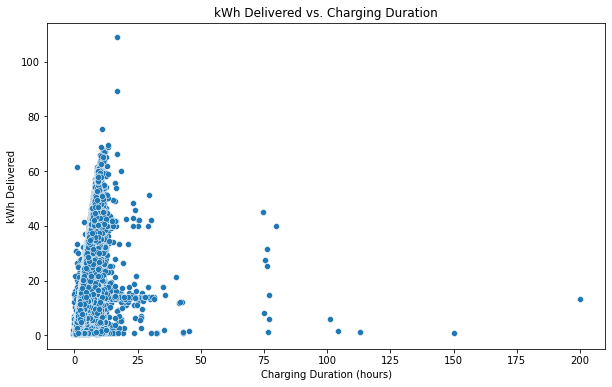

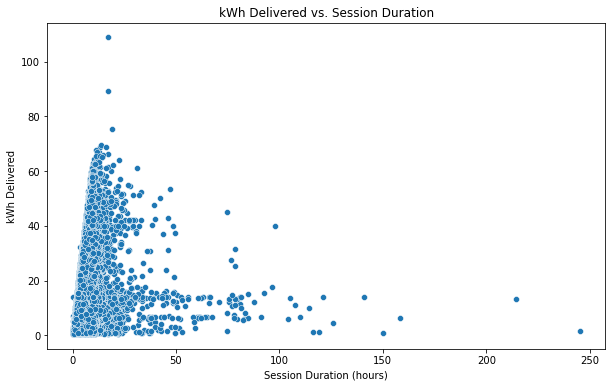

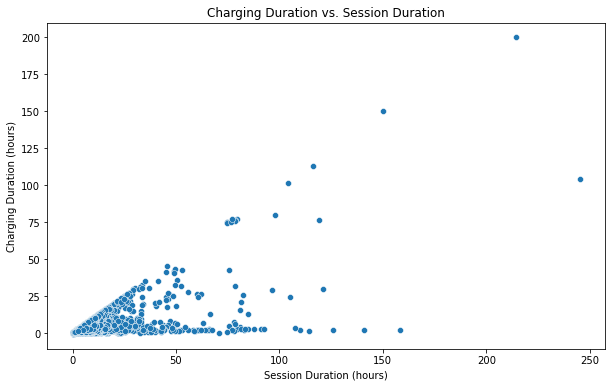

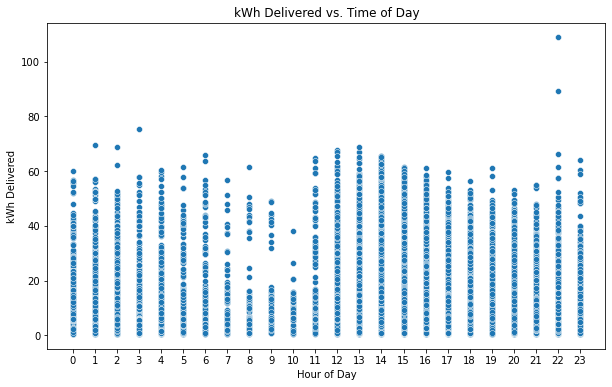

In [392]:
# OUTLIER DETECTION


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.charging_duration, y=df.kWhDelivered)
plt.title('kWh Delivered vs. Charging Duration')
plt.xlabel('Charging Duration (hours)')
plt.ylabel('kWh Delivered')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.session_duration, y=df.kWhDelivered)
plt.title('kWh Delivered vs. Session Duration')
plt.xlabel('Session Duration (hours)')
plt.ylabel('kWh Delivered')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.session_duration, y=df.charging_duration)
plt.title('Charging Duration vs. Session Duration')
plt.xlabel('Session Duration (hours)')
plt.ylabel('Charging Duration (hours)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.connectionTime.dt.hour, y=df.kWhDelivered)
plt.title('kWh Delivered vs. Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('kWh Delivered')
plt.xticks(range(0, 24))
plt.show()

# Visualization 

In [393]:
#connectionTime and disconnectTime
#doneChargingTime
#kWhDelivered
#WhPerMileb


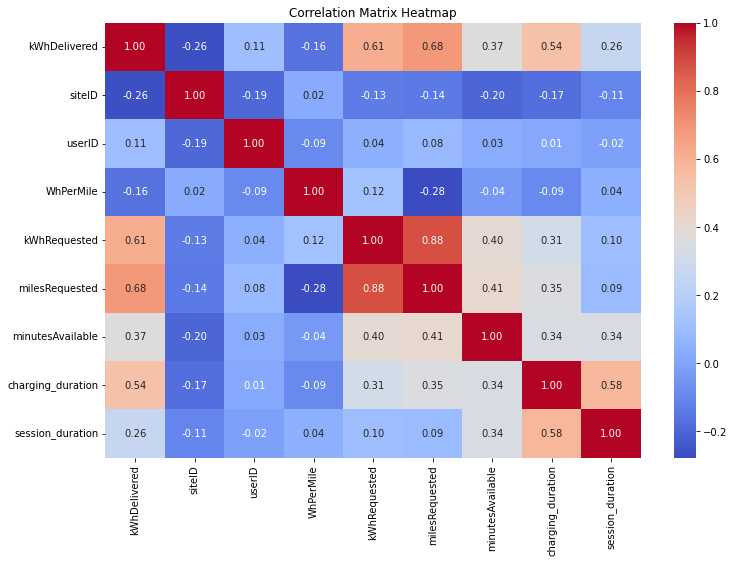

In [394]:
# Corr. matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()
# Finding: charging time has the largest "impact" on kWhDelivered

In [395]:
# Total Session Session Duration 
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 60
df['charging_time'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 60

In [396]:
session_duration_stats = {
    'mean': df['session_duration'].mean(),
    'median': df['session_duration'].median(),
    'standard_deviation': df['session_duration'].std(),
    'min': df['session_duration'].min(),
    'max': df['session_duration'].max(),
    '25th_percentile': df['session_duration'].quantile(0.25),
    '75th_percentile': df['session_duration'].quantile(0.75)
}

session_duration_stats

{'mean': 383.66721507755835,
 'median': 380.6666666666667,
 'standard_deviation': 293.45505804475096,
 'min': 3.05,
 'max': 14716.15,
 '25th_percentile': 180.21666666666667,
 '75th_percentile': 555.7416666666667}

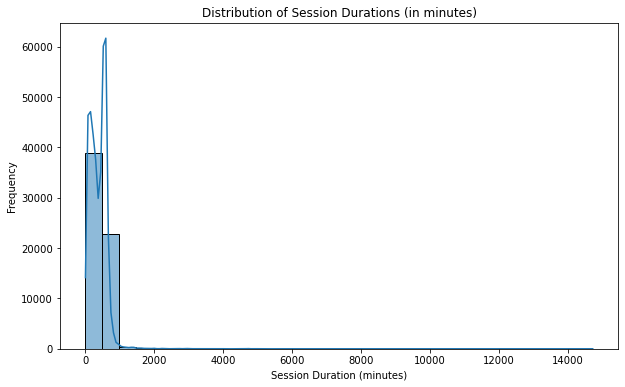

In [397]:
# Effective Charging time 
# Plot histogram of session durations
plt.figure(figsize=(10, 6))
sns.histplot(df['session_duration'], bins=30, kde=True)
plt.title("Distribution of Session Durations (in minutes)")
plt.xlabel("Session Duration (minutes)")
plt.ylabel("Frequency")
plt.show()


In [398]:
# Find entries with negative session_duration
print(df[df['session_duration'] < 0]),

Empty DataFrame
Columns: [id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, userID, WhPerMile, kWhRequested, milesRequested, minutesAvailable, modifiedAt, paymentRequired, requestedDeparture, charging_duration, session_duration, charging_time]
Index: []


(None,)

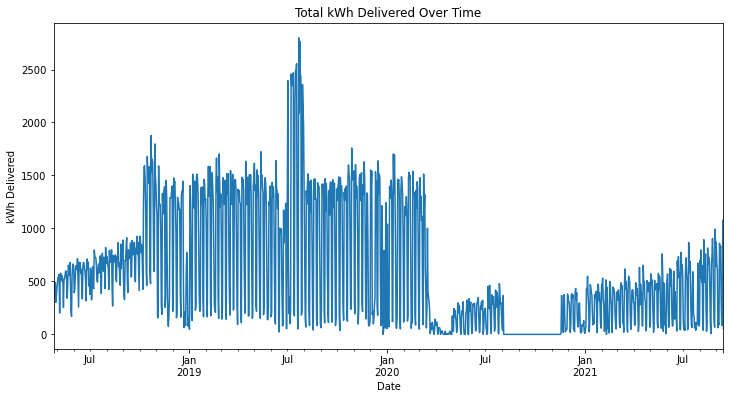

In [399]:
# kWh deilvered 
plt.figure(figsize=(12, 6))
df.set_index('connectionTime').resample('D')['kWhDelivered'].sum().plot()
plt.title("Total kWh Delivered Over Time")
plt.xlabel("Date")
plt.ylabel("kWh Delivered")
plt.show()

In [400]:
df

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,charging_duration,session_duration,charging_time
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,250.0,25.00,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",4.378056,362.350000,262.683333
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,280.0,70.00,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",6.687500,541.516667,401.250000
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,400.0,8.00,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",2.641944,642.783333,158.516667
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,400.0,8.00,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",1.313056,158.683333,78.783333
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,400.0,16.00,40.0,504.0,"Thu, 02 Jan 2020 14:00:13 GMT",True,"Thu, 02 Jan 2020 22:24:01 GMT",4.291389,488.650000,257.483333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66445,5d574ad2f9af8b4c10c03652,2019-07-31 18:08:04+00:00,2019-07-31 23:29:18+00:00,2019-07-31 23:30:18+00:00,28.787,1_1_179_809_2019-07-31 18:08:04.432654,1,AG-3F27,1-1-179-809,393.0,240.0,31.20,130.0,355.0,"Wed, 31 Jul 2019 18:08:23 GMT",True,"Thu, 01 Aug 2019 00:03:04 GMT",5.370556,321.233333,322.233333
66446,5d574ad2f9af8b4c10c03653,2019-07-31 18:40:41+00:00,2019-08-01 00:59:42+00:00,2019-07-31 21:44:23+00:00,7.787,1_1_179_810_2019-07-31 18:40:40.900203,1,AG-3F30,1-1-179-810,220.0,333.0,6.66,20.0,455.0,"Wed, 31 Jul 2019 18:41:02 GMT",True,"Thu, 01 Aug 2019 02:15:41 GMT",3.061667,379.016667,183.700000
66447,5d574ad2f9af8b4c10c03654,2019-07-31 19:04:40+00:00,2019-07-31 22:44:22+00:00,2019-07-31 22:45:21+00:00,11.274,1_1_191_795_2019-07-31 19:04:40.098273,1,AG-4F51,1-1-191-795,1974.0,333.0,19.98,60.0,184.0,"Wed, 31 Jul 2019 19:04:57 GMT",True,"Wed, 31 Jul 2019 22:08:40 GMT",3.678056,219.700000,220.683333
66448,5d574ad2f9af8b4c10c03655,2019-07-31 19:19:47+00:00,2019-08-01 00:34:51+00:00,2019-07-31 21:25:30+00:00,11.589,1_1_191_778_2019-07-31 19:19:46.919358,1,AG-4F43,1-1-191-778,942.0,275.0,22.00,80.0,60.0,"Wed, 31 Jul 2019 19:20:10 GMT",True,"Wed, 31 Jul 2019 20:19:47 GMT",2.095278,315.066667,125.716667


## Task 2

### A)

In [401]:
#Hour of Day
df["hour"] = df['connectionTime'].dt.hour

#Day of Week (Monday=0, Sunday=6)
df["dayOfWeek"] = df['connectionTime'].dt.dayofweek

#Month
df["month"] = df['connectionTime'].dt.month

#Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df["season"] = df['month'].apply(get_season)
hourly_counts = df.groupby('hour').size().reset_index(name='Charging Events')

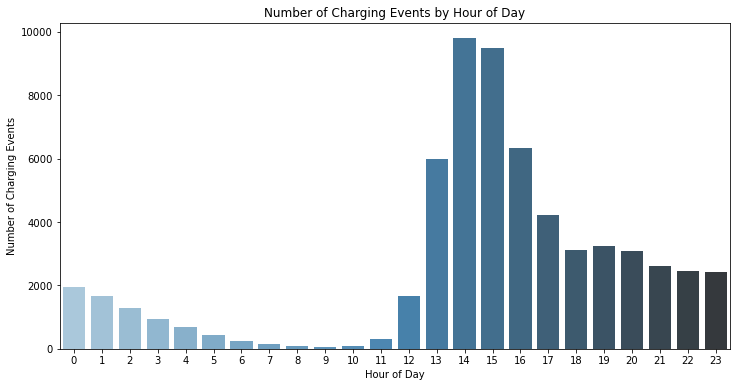

In [402]:
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=hourly_counts, palette='Blues_d')
plt.title('Number of Charging Events by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

### Mapping day numbers to names

In [403]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df['dayName'] = df['dayOfWeek'].map(day_names)

weekly_counts = df.groupby('dayName').size().reset_index(name='Charging Events')

### Ensure the days are in the correct order

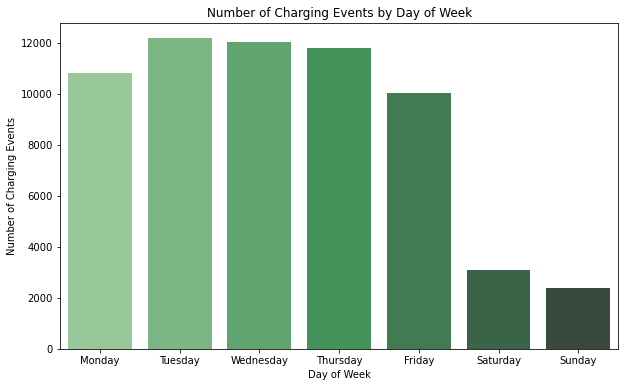

In [ ]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts['dayName'] = pd.Categorical(weekly_counts['dayName'], categories=order, ordered=True)
weekly_counts = weekly_counts.sort_values('dayName')

plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts, palette='Greens_d')
plt.title('Number of Charging Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()

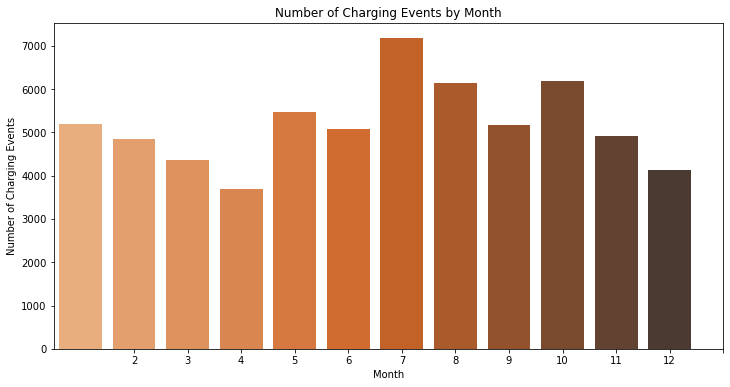

In [407]:
monthly_counts = df.groupby('month').size().reset_index(name='Charging Events')
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='Charging Events', data=monthly_counts, palette='Oranges_d')
plt.title('Number of Charging Events by Month')
plt.xlabel('Month')
plt.ylabel('Number of Charging Events')
plt.xticks(range(1, 13))
plt.show()